In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/home/purzelrakete/src/github.com


In [2]:
from pathlib import Path
import os
import pprint

import numpy as np
import torch
import librosa
from torch.nn import functional as F
import matplotlib.pyplot as plt
import IPython.display as ipd

from wavenet import model, train, sample, audio, datasets, utils, viz, debug

In [3]:
pp = pprint.PrettyPrinter(indent=2)

# Train on Maestro

In [4]:
# this cell contains papermill tagged parameters
# they can be overriden by the cli when training:  
# papermill in.ipynb out.ipynb -p batch_norm True

batch_norm = False
learning_rate = 0.0044
finder = False
batch_size = 12
max_epochs = 2

In [5]:
# Parameters
batch_size = 12
batch_norm = True
learning_rate = 0.05
max_epochs = 12


In [6]:
p = model.HParams(
    embed_inputs=True, 
    n_audio_chans=1, 
    squash_to_mono=True,
    batch_norm=batch_norm
)

pp.pprint(dict(p))

{ 'batch_norm': True,
  'compress': True,
  'dilation_stacks': 3,
  'embed_inputs': True,
  'kernel_size': 2,
  'mixed_precision': True,
  'n_audio_chans': 1,
  'n_chans': 128,
  'n_chans_embed': 256,
  'n_chans_end': 256,
  'n_chans_res': 96,
  'n_chans_skip': 256,
  'n_classes': 256,
  'n_layers': 11,
  'resample': True,
  'resampling_method': 'soxr_hq',
  'sample_from_gpu': True,
  'sample_length': 16000,
  'sampling_rate': 16000,
  'seed': 5763,
  'squash_to_mono': True,
  'use_deterministic_algorithms': False}


In [7]:
tp = train.HParams(
    max_epochs=max_epochs, 
    batch_size=batch_size, 
    num_workers=8, 
    finder=finder, 
    learning_rate=learning_rate
)

pp.pprint(dict(tp))

{ 'batch_size': 12,
  'betas': (0.9, 0.95),
  'callback_fq': 8,
  'finder': False,
  'grad_norm_clip': None,
  'learning_rate': 0.05,
  'max_epochs': 12,
  'num_workers': 8,
  'onecycle': True,
  'project_name': 'feldberlin-wavenet'}


In [8]:
utils.seed(p)
nas_path = Path('/srv/datasets/maestro/maestro-v2.0.0')
ssd_path = Path('/srv/datasets-ssd/maestro/maestro-v2.0.0')
ds_train, ds_test = datasets.maestro(nas_path, 2017, p, ssd_path)

In [9]:
utils.seed(p)
m = model.Wavenet(p)
debug.summarize(m)

+-------------------------------+------------+
|            Modules            | Parameters |
+-------------------------------+------------+
|          embed.weight         |   65536    |
|         shifted.weight        |   65536    |
|      shifted.norm.weight      |    128     |
|       shifted.norm.bias       |    128     |
|      layers.0.conv.weight     |   49152    |
|   layers.0.conv.norm.weight   |    192     |
|    layers.0.conv.norm.bias    |    192     |
|     layers.0.res1x1.weight    |   12288    |
|  layers.0.res1x1.norm.weight  |    128     |
|   layers.0.res1x1.norm.bias   |    128     |
|    layers.0.skip1x1.weight    |   24576    |
|  layers.0.skip1x1.norm.weight |    256     |
|   layers.0.skip1x1.norm.bias  |    256     |
|      layers.1.conv.weight     |   49152    |
|   layers.1.conv.norm.weight   |    192     |
|    layers.1.conv.norm.bias    |    192     |
|     layers.1.res1x1.weight    |   12288    |
|  layers.1.res1x1.norm.weight  |    128     |
|   layers.1.

In [10]:
t = train.Trainer(m, ds_train, ds_test, tp, None)
t.metrics

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: purzelrakete (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


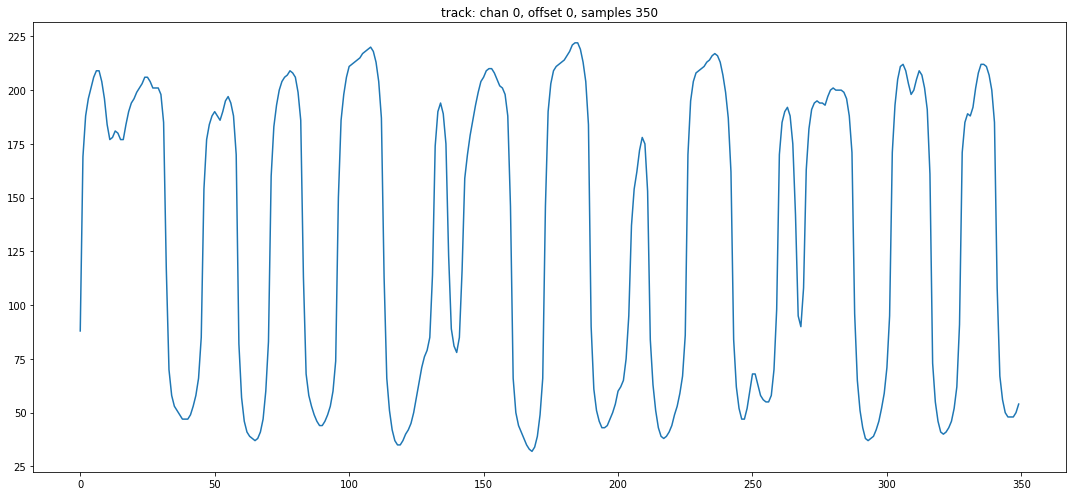

In [11]:
track_i = viz.plot_random_track(ds_train)
track, *_ = ds_train[track_i]
ipd.Audio(audio.mu_expand(track.squeeze().numpy(), p), rate=p.sampling_rate)

In [12]:
utils.seed(p)
tracks, logits, g = sample.fast(m, ds_train.transforms, utils.decode_nucleus(), n_samples=32000, batch_size=10)

In [14]:
for track in tracks:
    track = ds_train.transforms.normalise(track.numpy())
    track = audio.mu_expand(track, p)
    ipd.display(ipd.Audio(track, rate=p.sampling_rate))

In [15]:
t.metrics.finish()

learning rate,0.0
_runtime,41154
_timestamp,1630555278
_step,89723
train loss,1.40284
test loss,1.32169


learning rate,▁▁▂▂▃▄▅▆▆▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,█▇▄▄▅▅▄▄▄▅▄▄▄▄▃▃▃▅▂▄▂▂▂▃▂▂▄▂▃▃▄▂▂▂▂▁▂▃▂▁
test loss,█▇▆▆▅▄▄▄▃▂▁▁
